# CNN Example
Examplary PyTorch implementation of a convolutional neural network for image classification on the MNIST dataset.

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

data_root = "/Users/saeedida/Library/Mobile Documents/com~apple~CloudDocs/Conv-Aqtivate/cnns/exercise/data"

In [2]:
# Query the GPU
print(f"There are {torch.cuda.device_count()} GPUs available.")
# print(torch.cuda.get_device_name(torch.cuda.current_device()))

# # Saeed 
num_workers, pin_memory = 4, False
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # NVIDIA GPU
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple Silicon (Metal)
else:
    device = torch.device("cpu")

print(f"Device set to {device}")


There are 0 GPUs available.
Device set to mps


## Dataset and DataLoaders

[Datasets & DataLoaders Tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [3]:
# # Saeed

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# Define network architecture
We use the layer types `nn.Conv2d` and `nn.Linear` with the following signatures:
* `nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True)`
* `nn.Linear(in_features, out_features, bias=True)`

Pooling is done by `F.max_pool2d(input, kernel_size)`.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        
        x = x.view(-1, 20 * 4 * 4)  # Reshape to vector
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Data loading

In [5]:
# Setup input transformation
batch_size = 128
transformation = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))  # Standardization
                   ])

# Setup data loader
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(data_root, train=True, transform=transformation, download=True),
    batch_size=batch_size
)

## Setup model and optimizer

In [6]:
# device = torch.cuda.current_device()
# print(f"Using GPU {device}.")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)

## Training

In [7]:
def train_epoch(model, device, train_loader, optimizer):
    # Set network to training mode
    model.train()
    
    # Iterate over dataset
    losses = list()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to GPU
        data, target = data.to(device), target.to(device)
        
        # Clear gradients
        optimizer.zero_grad(set_to_none=True)
        
        # Compute output
        output = model(data)
        
        # Compute crossentropy loss
        loss = F.nll_loss(output, target)
        
        # Compute gradient
        loss.backward()
        
        # Perform gradient descent
        optimizer.step()
        
        # Track losses
        losses.append(loss.item())
    # Return loss at end of epoch
    return losses

In [8]:
losses = list()
for epoch in tqdm(range(5)):
    epoch_losses = train_epoch(model, device, train_loader, optimizer)
    print(f"Average loss in epoch {epoch}: {np.mean(epoch_losses):.5f}")
    losses.extend(epoch_losses)

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:07<00:30,  7.52s/it]

Average loss in epoch 0: 1.05505


 40%|████      | 2/5 [00:14<00:21,  7.32s/it]

Average loss in epoch 1: 0.59956


 60%|██████    | 3/5 [00:22<00:14,  7.36s/it]

Average loss in epoch 2: 0.51311


 80%|████████  | 4/5 [00:29<00:07,  7.36s/it]

Average loss in epoch 3: 0.45768


100%|██████████| 5/5 [00:36<00:00,  7.38s/it]

Average loss in epoch 4: 0.41862


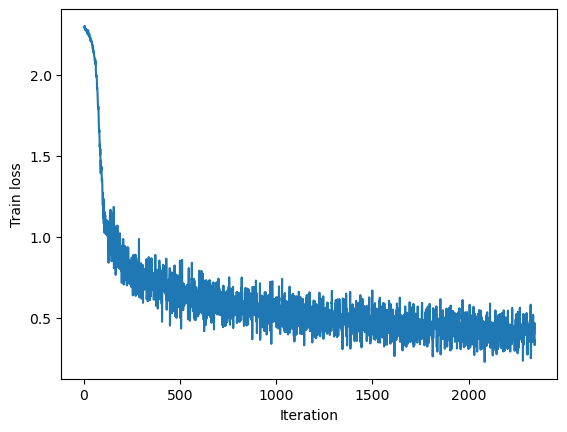

In [9]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Train loss")
plt.show()